In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/1017.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/641.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/1088.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/173.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/815.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/491.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/1084.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/718.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/709.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/889.png
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp/379.png
/kaggle/input/a-cu

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split 

In [8]:
class DataPreprocessor:
    def __init__(self, base_path, target_size=(256, 256)):
        self.base_path = base_path
        self.target_size = target_size
        self.blurred_images = []
        self.sharp_images = []
        
    def load_and_preprocess_image(self, image_path):
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img.astype(np.float32) / 255.0
            return img
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return None

    def create_dataset(self, blurred_dir, sharp_dir):
        print("Loading and preprocessing images...")
        blurred_files = sorted(os.listdir(blurred_dir))
        sharp_files = sorted(os.listdir(sharp_dir))
        
        for blur_file, sharp_file in zip(blurred_files, sharp_files):
            blur_path = os.path.join(blurred_dir, blur_file)
            sharp_path = os.path.join(sharp_dir, sharp_file)
            blur_img = self.load_and_preprocess_image(blur_path)
            sharp_img = self.load_and_preprocess_image(sharp_path)
            if blur_img is not None and sharp_img is not None:
                self.blurred_images.append(blur_img)
                self.sharp_images.append(sharp_img)
        
        self.blurred_images = np.array(self.blurred_images)
        self.sharp_images = np.array(self.sharp_images)
        print(f"Loaded {len(self.blurred_images)} image pairs")
    def split_dataset(self, test_size=0.2, validation_size=0.1):
        """
        Split dataset into train, validation and test sets
        """
        # First split into train+val and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.blurred_images, 
            self.sharp_images, 
            test_size=test_size, 
            random_state=42
        )
        
        # Then split train into train and validation
        val_size = validation_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, 
            y_train_val, 
            test_size=val_size, 
            random_state=42
        )
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def visualize_samples(self, num_samples=5):
        """
        Visualize random samples from the dataset
        """
        indices = np.random.randint(0, len(self.blurred_images), num_samples)
        
        plt.figure(figsize=(15, 3*num_samples))
        for i, idx in enumerate(indices):
            # Plot blurred image
            plt.subplot(num_samples, 2, 2*i + 1)
            plt.imshow(self.blurred_images[idx])
            plt.title('Blurred Image')
            plt.axis('off')
            
            # Plot sharp image
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.imshow(self.sharp_images[idx])
            plt.title('Sharp Image')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [9]:
class DeblurModel:
    def __init__(self, input_shape=(256, 256, 3)):
        self.input_shape = input_shape
        self.model = None
        
    def residual_block(self, x, filters):
        x = layers.Conv2D(filters, kernel_size=1, padding='same')(x)
        res = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        res = layers.BatchNormalization()(res)
        res = layers.ReLU()(res)
        res = layers.Conv2D(filters, kernel_size=3, padding='same')(res)
        res = layers.BatchNormalization()(res)
        out = layers.Add()([res, x])
        out = layers.ReLU()(out)
        return out
    
    def encoder_block(self, x, filters):
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p
    
    def decoder_block(self, x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x
    
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        s1, p1 = self.encoder_block(inputs, 64)
        s2, p2 = self.encoder_block(p1, 128)
        s3, p3 = self.encoder_block(p2, 256)
        s4, p4 = self.encoder_block(p3, 512)
        b1 = self.residual_block(p4, 512)
        b2 = self.residual_block(b1, 512)
        d1 = self.decoder_block(b2, s4, 512)
        d2 = self.decoder_block(d1, s3, 256)
        d3 = self.decoder_block(d2, s2, 128)
        d4 = self.decoder_block(d3, s1, 64)
        outputs = layers.Conv2D(3, 1, padding='same', activation='sigmoid')(d4)
        self.model = Model(inputs, outputs, name='DeblurNet')
        return self.model
    
    def custom_loss(self):
        mse = MeanSquaredError()
        mae = MeanAbsoluteError()
        
        def loss(y_true, y_pred):
            return (0.5 * mse(y_true, y_pred) + 
                    0.3 * mae(y_true, y_pred))
        return loss

# Training Configuration Class
class TrainingConfig:
    def __init__(self):
        self.BATCH_SIZE = 8  # Adjusted for memory efficiency
        self.EPOCHS = 100
        self.LEARNING_RATE = 1e-4
        self.CHECKPOINT_PATH = "/kaggle/working/checkpoints/deblur_model.weights.h5"

# Main Training Function
def train_model(train_generator, val_generator, config):
    os.makedirs('checkpoints', exist_ok=True)
    
    # Enable mixed precision
    # Enable mixed precision
    mixed_precision.set_global_policy('mixed_float16')

    
    # Initialize model
    deblur_model = DeblurModel(input_shape=(256, 256, 3))
    model = deblur_model.build_model()
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE),
        loss=deblur_model.custom_loss(),
        metrics=['mse', 'mae']
    )
    
    # Create checkpoint callback
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=config.CHECKPOINT_PATH,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train model using the generator
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=config.EPOCHS,
        callbacks=[checkpoint_callback, early_stopping],
        verbose=1
    )
    
    return model, history


In [10]:
preprocessor = DataPreprocessor(
        base_path='/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro',
        target_size=(256, 256)
    )
    
    # Create dataset
blurred_dir = '/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur'
sharp_dir = '/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp'
preprocessor.create_dataset(blurred_dir, sharp_dir)
    
    # Split dataset
X = preprocessor.blurred_images
y = preprocessor.sharp_images
    
    # Ensure both X and y are numpy arrays
X = np.array(X)
y = np.array(y)

    # Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
    
    # Create data generators
train_generator = DataGenerator(X_train, y_train, batch_size=TrainingConfig().BATCH_SIZE)
val_generator = DataGenerator(X_val, y_val, batch_size=TrainingConfig().BATCH_SIZE)
    
    # Train the model
config = TrainingConfig()
model, history = train_model(train_generator, val_generator, config)
    
    # Save the final model (optional)
model.save('final_deblur_model.keras')

Loading and preprocessing images...
Loaded 2103 image pairs
Epoch 1/100


I0000 00:00:1734638341.767503      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_151', 8 bytes spill stores, 8 bytes spill loads



210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0309 - mae: 0.0780 - mse: 0.0149
Epoch 1: val_loss improved from inf to 0.06762, saving model to /kaggle/working/checkpoints/deblur_model.weights.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - loss: 0.0308 - mae: 0.0779 - mse: 0.0149 - val_loss: 0.0676 - val_mae: 0.1622 - val_mse: 0.0379
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0159 - mae: 0.0450 - mse: 0.0048
Epoch 2: val_loss improved from 0.06762 to 0.03627, saving model to /kaggle/working/checkpoints/deblur_model.weights.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 237ms/step - loss: 0.0159 - mae: 0.0450 - mse: 0.0048 - val_loss: 0.0363 - val_mae: 0.0971 - val_mse: 0.0143
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0156 - mae: 0.0442 - mse: 0.0046
Epoch 3: val_loss improved from 0.03627 to 0.01627, saving model to /kaggle/working/checkpoints/deblur_model.weights.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 237ms/step - loss: 0.0156 - mae: 0.0442 - mse

In [11]:
def plot_training_results(history):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
# Function to test the trained model
# Function to test the trained model
def test_model(model, test_images):
    plt.figure(figsize=(35, 25))
    for i in range(min(5, len(test_images))):  # Display up to 5 test images
        # Get blurred image
        blurred_image = test_images[i]
        
        # Make prediction
        deblurred_image = model.predict(np.expand_dims(blurred_image, axis=0))[0]
        
        # Ensure the deblurred image is in the correct range
        deblurred_image = np.clip(deblurred_image, 0, 1)  # Clip values to [0, 1]
        
        # Convert images to uint8 for plotting
        blurred_image = (blurred_image * 255).astype(np.uint8)
        deblurred_image = (deblurred_image * 255).astype(np.uint8)
        
        # Plot original blurred image
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(blurred_image)
        plt.title('Blurred Image')
        plt.axis('off')
        
        # Plot deblurred image
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(deblurred_image)
        plt.title('Deblurred Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

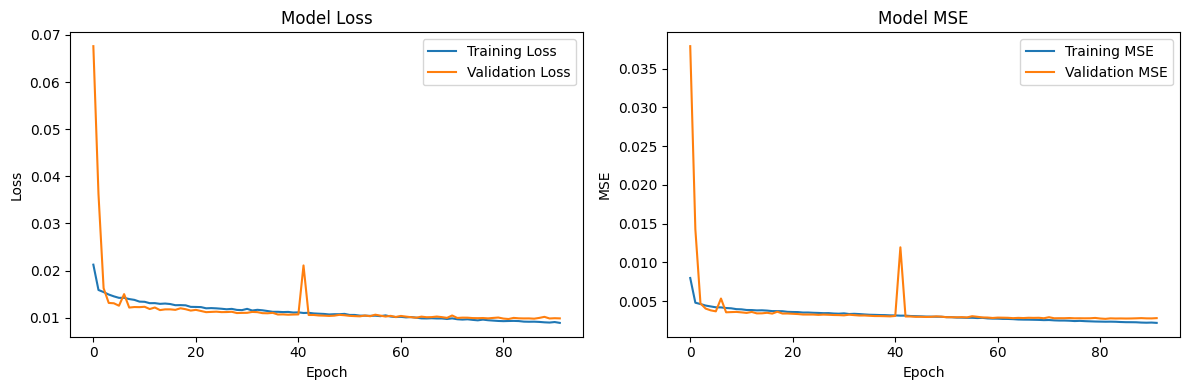

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


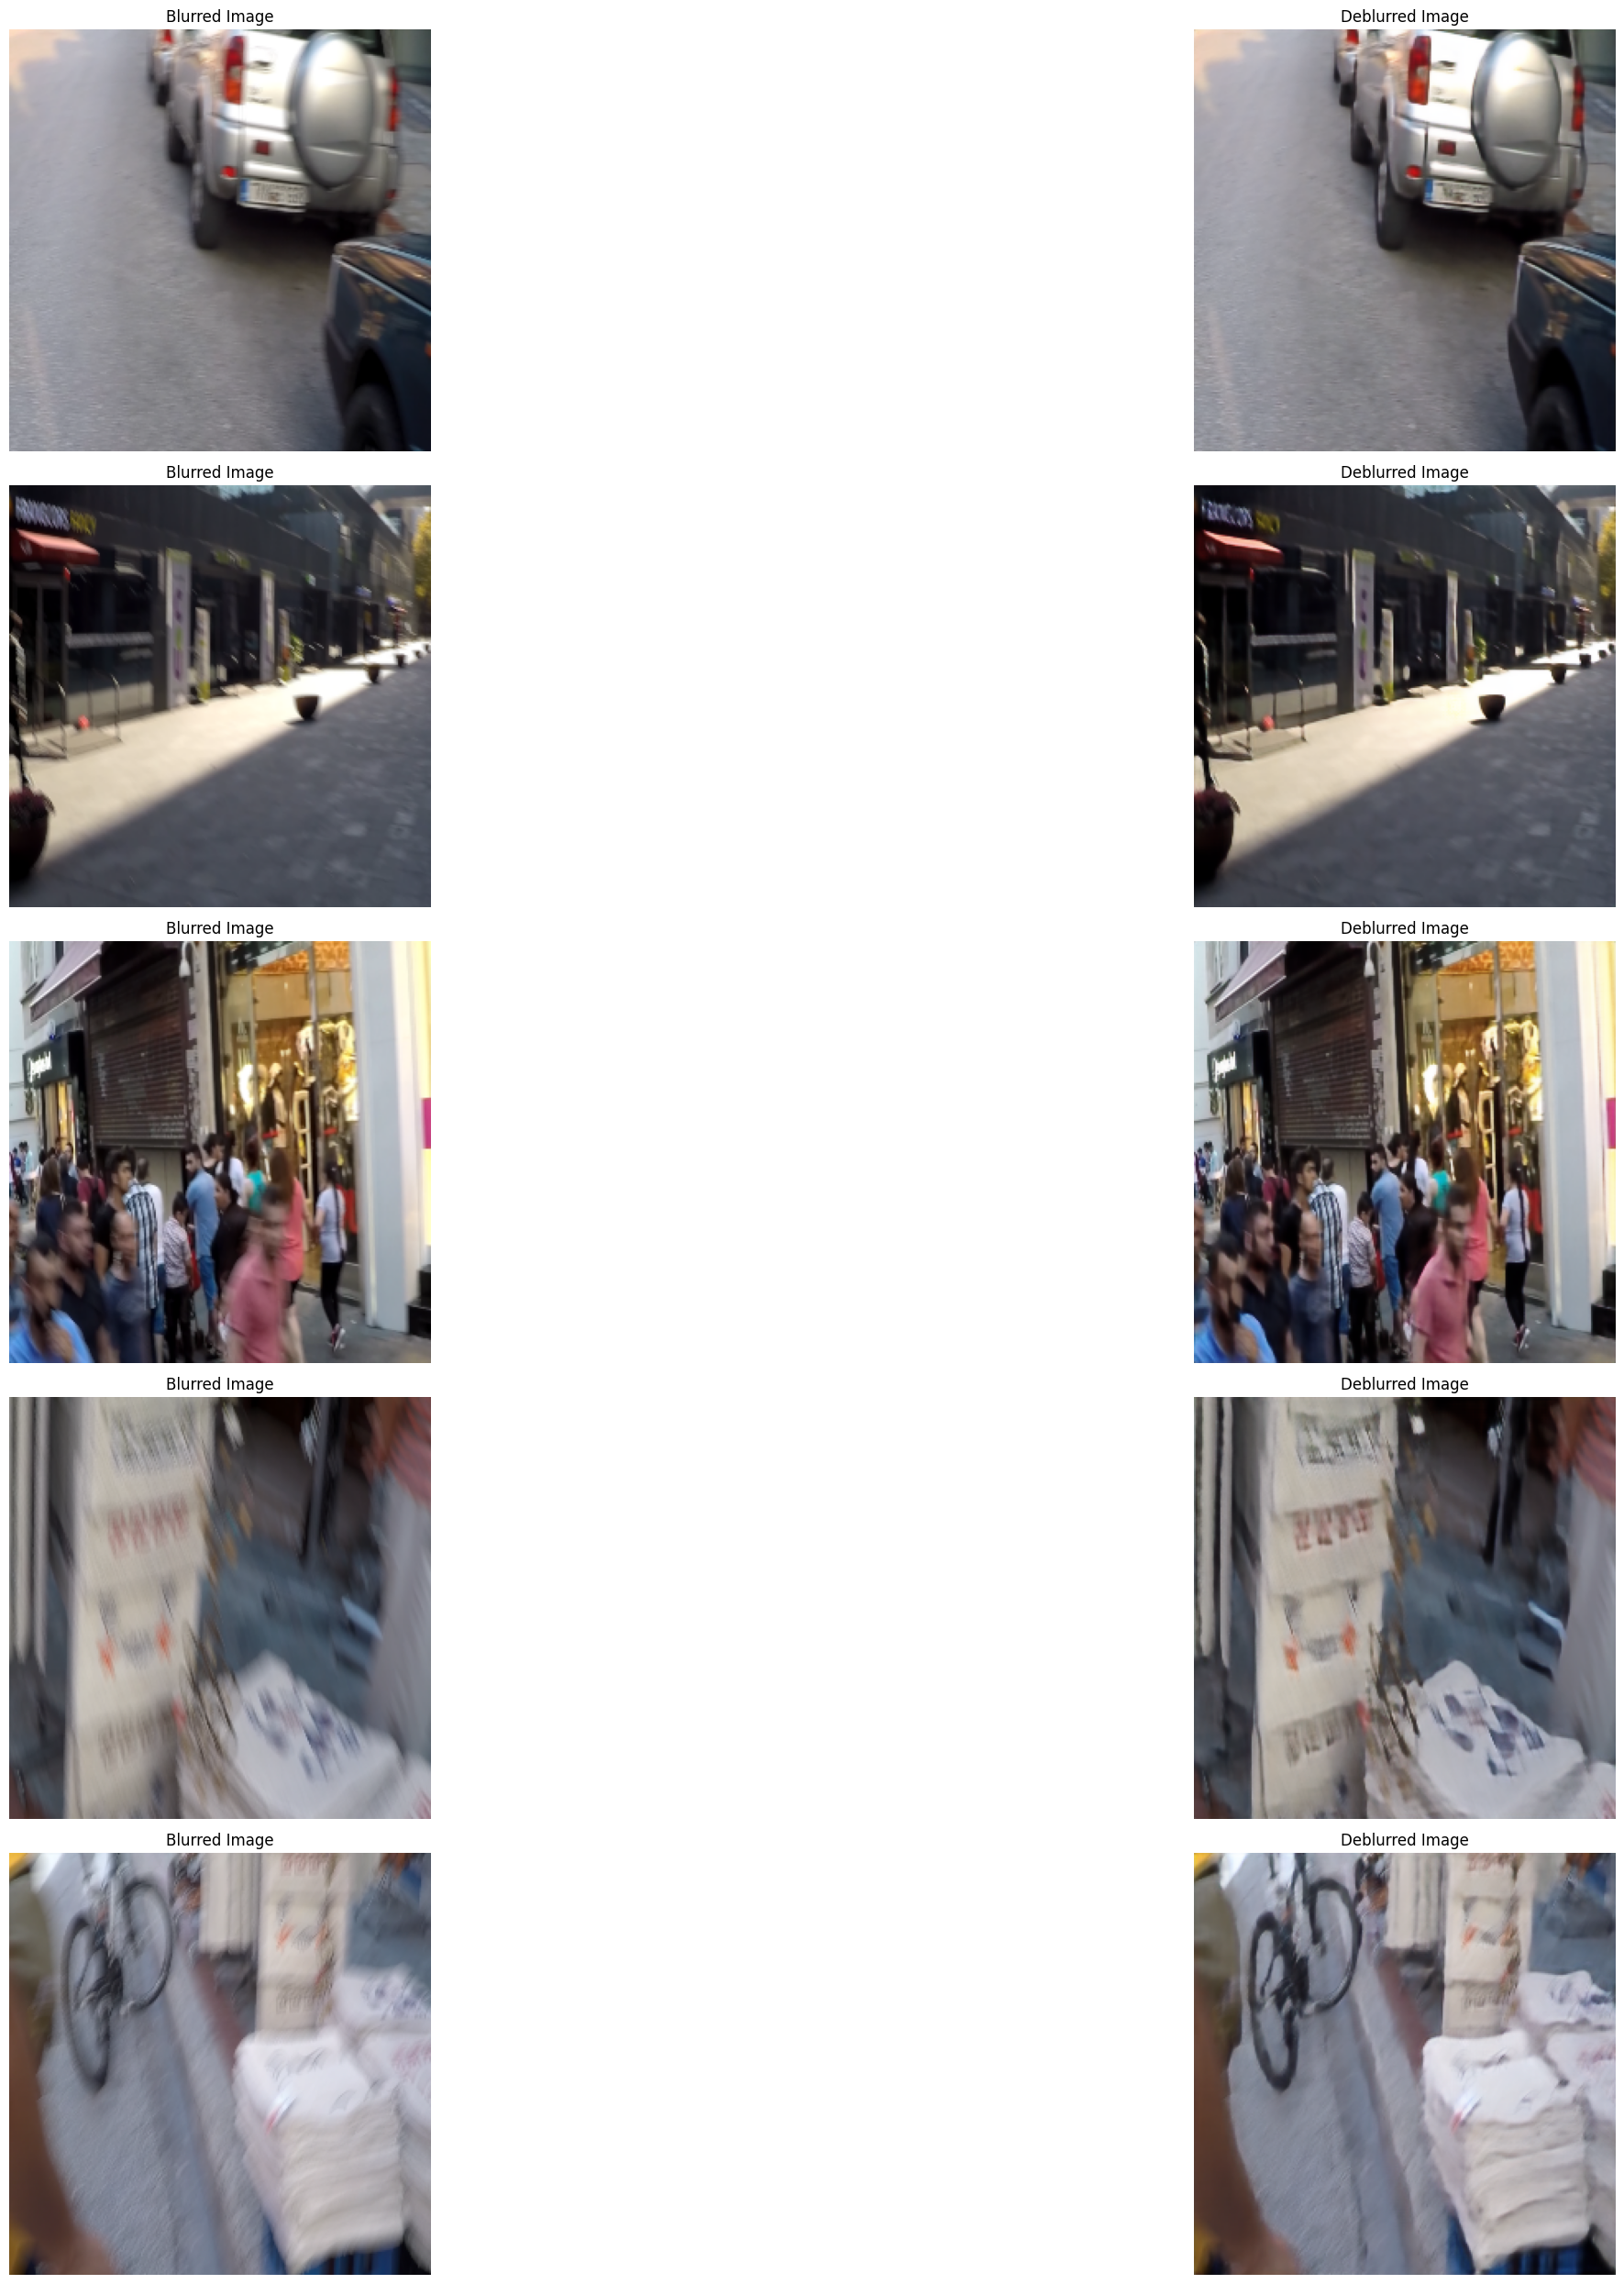

In [21]:
plot_training_results(history)
    
    # Test the model with some test images
test_images = X_val  # You can use a separate test set if available
test_model(model, test_images)
    
    # Save the final model (optional)
model.save('final_deblur_model.keras')